# Introducción

Uno de mis problemas favoritos, y razón de mi proyecto final de grado, es el problema del viajero (Traveling Salesman Problem) y sus multiples evoluciones del problema de ruteo de vehículo (Vehicle Routing Problem).

## Funciones útiles

En esta sección se definirán funciones que serán útiles a lo largo del notebook. Si no le interesa leer código, solo córralo.

In [1]:
#Importar librerias

import random
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial.distance import cdist
from ortools.linear_solver import pywraplp

load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\zlib1.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\abseil_dll.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\utf8_validity.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\re2.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\libprotobuf.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\highs.dll...
load c:\Users\josek\Desktop\ProyectosPersonales\InvestigacionOperativa\.venv\Lib\site-packages\ortools\.libs\ortools.dll...


In [ ]:
def create_2d_points_df(n, seed):
  """
  Genera n puntos en un espacio 2D y los guarda en un dataframe de pandas.

  Args:
    n: número de puntos
    seed: semilla aleatoria usada para por hacer reproducible el código

  Returns:
    Un dataframe de Pandas con las columnas "x", e "y".
  """
  points_data = []
  random.seed(seed)
  for i in range(n):
    x = random.uniform(-100, 100)
    y = random.uniform(-100, 100)
    points_data.append({'x': x, 'y': y})

  df = pd.DataFrame(points_data)
  return df


def calculate_distance(df):
  """
 Toma un dataframe con columnas 'x' e 'y' y calcula las distancias euclídeas

  Args:
    df: dataframe de pandas con columnas 'x' e 'y'.

  Returns:
    Una matriz de distancias euclídeas.
  """
  coords = df[['x', 'y']].values
  distance_matrix = cdist(coords, coords, metric='euclidean')
  return distance_matrix

def plot_points(df):
  """
  Plotea los puntos generados por create_2d_points_df.

  Args:
    df: df: dataframe de pandas con columnas 'x' e 'y'.
  """
  x_coords = df['x'].tolist()
  y_coords = df['y'].tolist()

  plt.figure(figsize=(8, 8))
  plt.scatter(x_coords, y_coords)
  plt.title('Puntos en el espacio 2D')
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.grid(True)
  plt.show()


def points_sub(points, i):
    """
    De una lista de numeros sustrae el numero i en una copia nueva.
    Se considera que poinla lista no tiene elementos duplicados (por ser lista de indices) y que i se encuentra en la lista.

    Args:
      points: lista de puntos.
      i: elemento a sustraer de la lista

    Returns:
      new: lista nueva similar a points pero sin el elemento i.
    """
    new = points.copy()
    new.remove(i)
    return new

## Traveling Salesman Problem

En el problema del viajero, se tiene un set V de n nodos, con sus costos c<sub>ij</sub> asociados (costos de ir del nodo i al j). Con la condición de visitar cada nodo una única vez, se busca el mínimo costo para este circuito.

Si bien la formulación más utilizada para resolver este problema lineal entero es la de Dantzig–Fulkerson–Johnson (DFJ), este ejemplo se realizará con la formulación de Miller–Tucker–Zemlin (MTZ) por ser la más sencilla de explicar en la eliminación de subtours.


Solo con la definición del TSP, podríamos plantear el siguiente problema: 

Siendo:
- x<sub>ij</sub> una variable binaria si se viaja de i hacia j
- c<sub>ij</sub> el costo de ir de i a j

Minimizar:
$$
\min \sum_{i=1}^{n} \sum_{\substack{j=1 \\ j \ne i}}^{n} c_{ij} x_{ij}
$$

Sujeto a:

$$
\sum_{\substack{i=1 \\ i \ne j}}^{n} x_{ij} = 1 \quad \text{para } j = 1, \dots, n;
$$

$$
\sum_{\substack{j=1 \\ j \ne i}}^{n} x_{ij} = 1 \quad \text{para } i = 1, \dots, n;
$$

$$
x_{ij} \in \{0, 1\} \quad \text{para } i, j = 1, \dots, n;
$$

Para ver que es necesario cierto trabajo extra, vamos a tratar de resolver este caso:

Suponer que se tienen 10 puntos aleatorios en el espacio definidos a continuación:

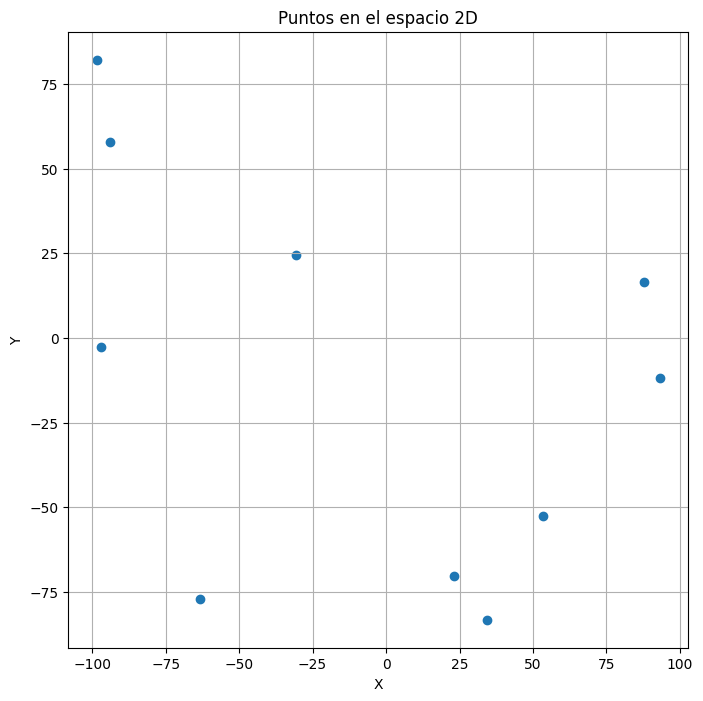

In [3]:
# Defino una semilla
seed = 1234

# Genero los puntos
puntos = create_2d_points_df(10, seed)

# Ploteo los puntos
plot_points(puntos)

# Calculo distancias
distancias = calculate_distance(puntos)

In [4]:
# Definimos el modelo
modelo = pywraplp.Solver.CreateSolver('SAT')

list_index_puntos = list(puntos.index)

# Definimos variables

x_ij={i:{j: modelo.IntVar(0,1,'x_'+str(i)+'_'+str(j)) for j in points_sub(list_index_puntos, i)} for i in list_index_puntos}

# Definimos la función objetivo
obj_expr = sum(x_ij[i][j] * distancias[i][j] for i in list_index_puntos for j in points_sub(list_index_puntos, i))


#Restricciones:

#1
for j in list_index_puntos:
    modelo.Add(sum(x_ij[i][j] for i in points_sub(list_index_puntos, j)) == 1)

#2
for i in list_index_puntos:
    modelo.Add(sum(x_ij[i][j] for j in points_sub(list_index_puntos, i)) == 1)


# Solver
modelo.Minimize(obj_expr)

In [5]:
# Llamamos al solver
status = modelo.Solve()

In [6]:
modelo.Objective().Value()

455.67597195654463

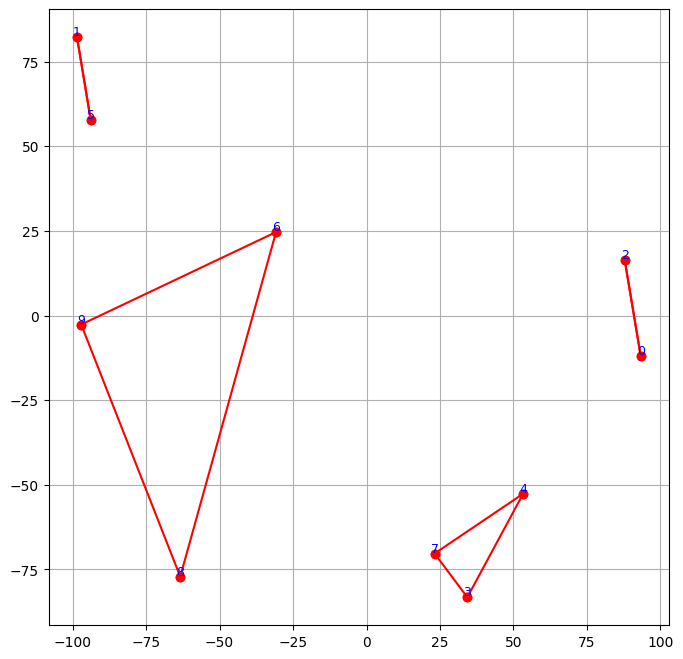

In [ ]:
# Ploteamos resultado (ToDo: pasarlo a func)

plt.figure(figsize=(8, 8))
plt.grid(True)
for i in list_index_puntos:
    for j in points_sub(list_index_puntos, i):
        if x_ij[i][j].SolutionValue() == 1:
            plt.plot(puntos.iloc[[i,j]]['x'], puntos.iloc[[i,j]]['y'], 'ro-')
            plt.text(puntos.iloc[i]['x'], puntos.iloc[i]['y'] + 0.5, str(i), ha='center', fontsize=9, color='blue')    
plt.show()

El problema que encontramos es que nada impide al modelo a generar subtours, esto es, aislar ciertos nodos en un tours cerrado propio, cuando lo que buscamos lograr es que sea en un solo viaje.

Para solucionar esta problematica es que exiten las formulaciones DFJ y MTZ (entre otras). MTZ presenta una nueva variable dummy la cual indica el órden en que son visitados los nodos.